In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("Spotify Data Analysis") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Configurar para mejor rendimiento
spark.conf.set("spark.sql.shuffle.partitions", "8")

In [3]:
# Carga de archivos
tracks_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("work/data/tracks.csv")

artists_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("work/data/artists.csv")

# Examinar el esquema
print("Esquema de tracks_df:")
tracks_df.printSchema()

print("\nEsquema de artists_df:")
artists_df.printSchema()

# Ver las primeras filas
print("\nPrimeras 5 filas de tracks_df:")
tracks_df.show(5)

print("\nPrimeras 5 filas de artists_df:")
artists_df.show(5)

# Información básica
track_count = tracks_df.count()
artist_count = artists_df.count()
print(f"Total de canciones: {track_count}")
print(f"Total de artistas: {artist_count}")

Esquema de tracks_df:
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)


Esquema de artists_df:
root
 |-- id: string (nullable = true)
 |-- followers: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- name: string (n

## Procesamiento y limpieza

In [4]:
# Verificar valores nulos en tracks_df
tracks_nulls = tracks_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in tracks_df.columns])
tracks_nulls.show()

# Verificar valores nulos en artists_df
artists_nulls = artists_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in artists_df.columns])
artists_nulls.show()

+---+----+----------+-----------+--------+-------+----------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
| id|name|popularity|duration_ms|explicit|artists|id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|time_signature|
+---+----+----------+-----------+--------+-------+----------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|  0|  71|         0|          0|       0|      0|        12|          12|          12|    12| 12|      12|  12|         12|          12|              12|      12|     12|   12|            12|
+---+----+----------+-----------+--------+-------+----------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+

+---+---------+------+----+-------

In [ ]:
# Convertir columnas numéricas que están como string a su tipo correcto
numeric_cols = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 
                'loudness', 'mode', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

for col_name in numeric_cols:
    tracks_df = tracks_df.withColumn(col_name, F.col(col_name).cast(FloatType()))

# Convertir duración de ms a minutos
tracks_df = tracks_df.withColumn("duration_min", F.col("duration_ms") / 60000)

# Extraer el año de release_date (que puede venir en varios formatos)
tracks_df = tracks_df.withColumn(
    "release_year",
    F.when(F.col("release_date").rlike("^\\d{4}$"), F.col("release_date"))  # Si es solo año (YYYY)
    .when(F.col("release_date").rlike("^\\d{4}-\\d{2}-\\d{2}$"), F.substring(F.col("release_date"), 1, 4))  # Si es YYYY-MM-DD
    .when(F.col("release_date").rlike("^\\d{2}/\\d{2}/\\d{4}$"), F.substring(F.col("release_date"), 7, 4))  # Si es MM/DD/YYYY
    .otherwise(None)  # Otros formatos no reconocidos
).withColumn("release_year", F.col("release_year").cast(IntegerType()))

# Procesar columna de artistas 
tracks_df = tracks_df.withColumn(
    "artists_array",
    F.regexp_replace(F.regexp_replace(F.col("artists"), "^\\[", ""), "\\]$", "")
).withColumn(
    "artists_array",
    F.split(F.regexp_replace(F.col("artists_array"), "'", ""), ",")
)

# Rangos de años y filtrar valores incorrectos
min_year = 1900 
max_year = 2023 

tracks_df = tracks_df.filter(
    (F.col("release_year").isNull() | 
     ((F.col("release_year") >= min_year) & (F.col("release_year") <= max_year))
))

# Eliminar registros con valores implausibles
tracks_clean = tracks_df.filter(
    (F.col("duration_min") > 0) &  # Duración positiva
    (F.col("duration_min") < 60) &  # Menos de 1 hora
    (F.col("popularity") >= 0) & (F.col("popularity") <= 100) &  # Popularidad entre 0-100
    (F.col("danceability") >= 0) & (F.col("danceability") <= 1) &  # Valores entre 0-1
    (F.col("energy") >= 0) & (F.col("energy") <= 1) &
    (F.col("speechiness") >= 0) & (F.col("speechiness") <= 1) &
    (F.col("acousticness") >= 0) & (F.col("acousticness") <= 1) &
    (F.col("instrumentalness") >= 0) & (F.col("instrumentalness") <= 1) &
    (F.col("liveness") >= 0) & (F.col("liveness") <= 1) &
    (F.col("valence") >= 0) & (F.col("valence") <= 1)
)

tracks_clean = tracks_clean.drop("duration_ms")

In [ ]:
# Dataframe limpio
tracks_clean.printSchema()

# Contar registros después de la limpieza
print(f"Total de canciones después de limpieza: {tracks_clean.count()}")

# Mostrar algunas estadísticas descriptivas
tracks_clean.select("duration_min", "popularity", "release_year").summary().show()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- duration_min: double (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- artists_array: array (nullable = true)
 |    |-- element: string (containsNull = false)

Total de canciones después de limpieza: 583278
+-------+--

In [7]:
# Limpieza básica de artists_df
artists_clean = artists_df.dropDuplicates(["id"])

# Verificar si hay nombres de artistas nulos
artists_clean = artists_clean.filter(F.col("name").isNotNull())

print(f"Total de artistas únicos después de limpieza: {artists_clean.count()}")

Total de artistas únicos después de limpieza: 1162095


## EDA


#### Distribución de Características Musicales

In [8]:
audio_features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 
                 'liveness', 'valence', 'speechiness', 'tempo', 'loudness']

In [9]:
from pyspark.sql.functions import mean, median, stddev, min, max, count

# Estadísticas descriptivas para cada característica
for feature in audio_features:
    tracks_clean.select(
        count(feature).alias(f"count_{feature}"),
        mean(feature).alias(f"mean_{feature}"),
        median(feature).alias(f"median_{feature}"),
        stddev(feature).alias(f"std_{feature}"),
        min(feature).alias(f"min_{feature}"),
        max(feature).alias(f"max_{feature}")
    ).show()

+------------------+------------------+-------------------+-------------------+----------------+----------------+
|count_danceability| mean_danceability|median_danceability|   std_danceability|min_danceability|max_danceability|
+------------------+------------------+-------------------+-------------------+----------------+----------------+
|            583278|0.5644411421693492|  0.578000009059906|0.16551800212487972|             0.0|           0.991|
+------------------+------------------+-------------------+-------------------+----------------+----------------+

+------------+------------------+-----------------+------------------+----------+----------+
|count_energy|       mean_energy|    median_energy|        std_energy|min_energy|max_energy|
+------------+------------------+-----------------+------------------+----------+----------+
|      583278|0.5433521234592484|0.550000011920929|0.2513022357804888|       0.0|       1.0|
+------------+------------------+-----------------+------

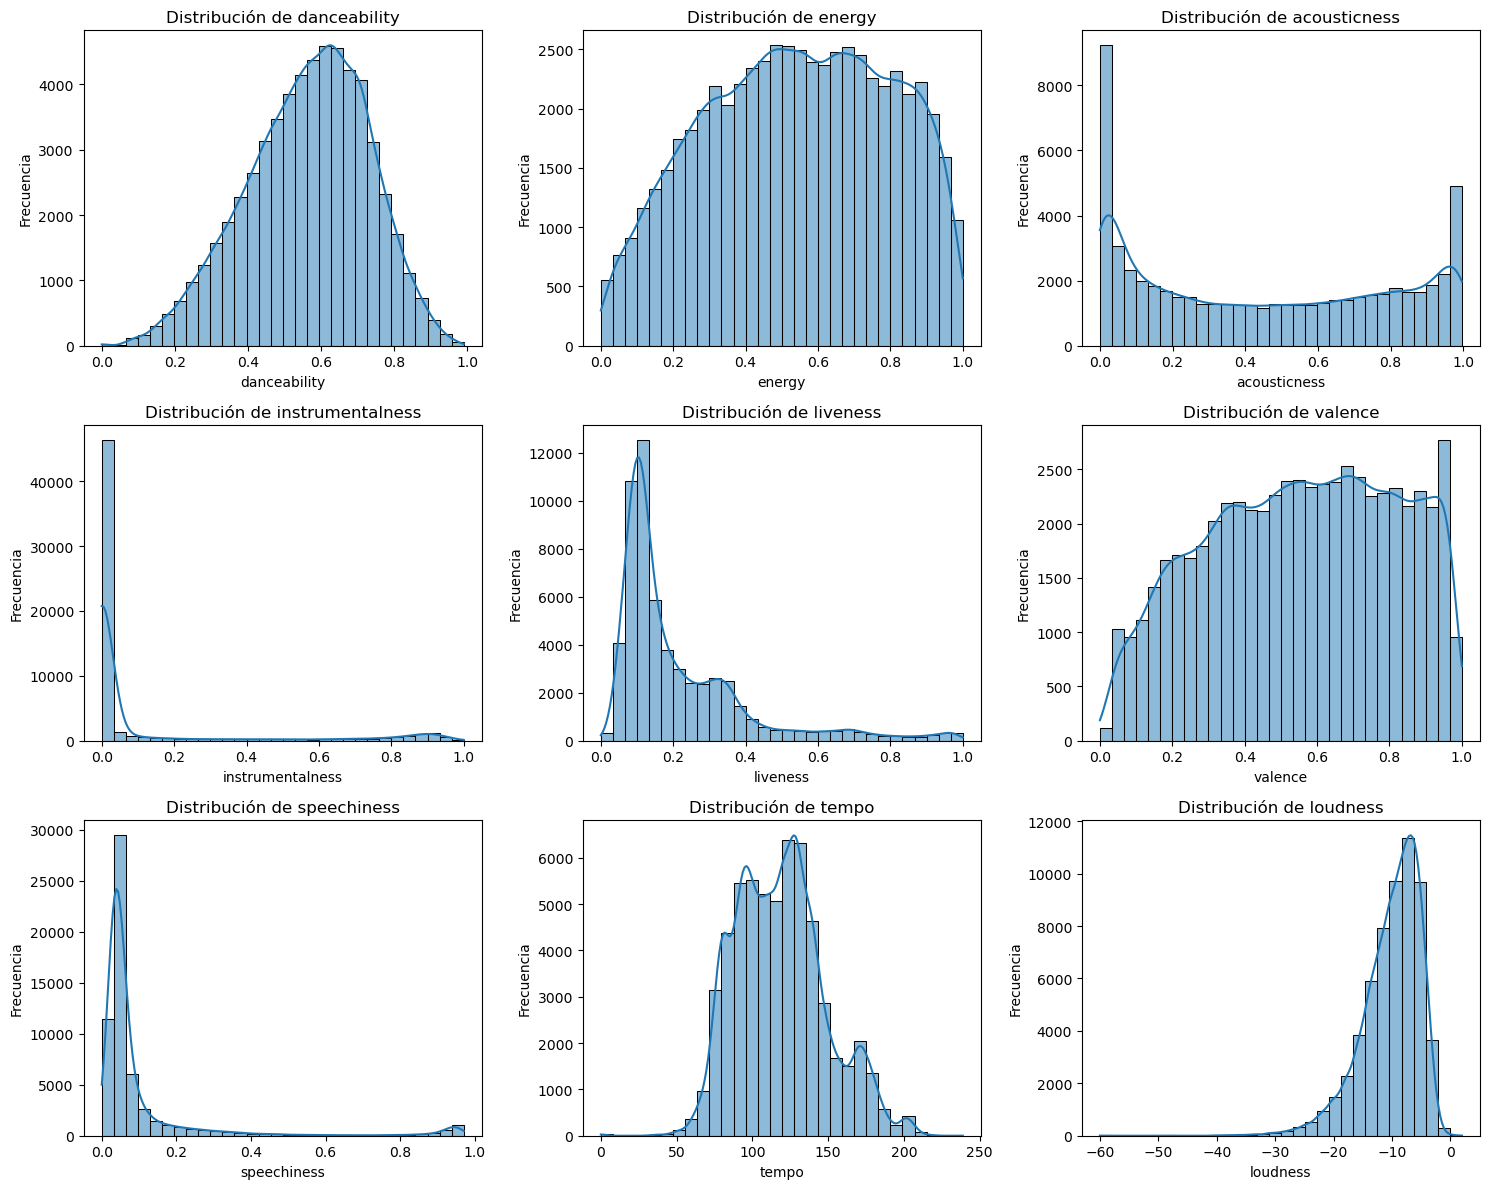

In [ ]:
# Muestrear los datos para visualización 
sample_df = tracks_clean.select(audio_features).sample(fraction=0.1, seed=42).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
for i, feature in enumerate(audio_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(sample_df[feature], bins=30, kde=True)
    plt.title(f'Distribución de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    
plt.tight_layout()
plt.show()

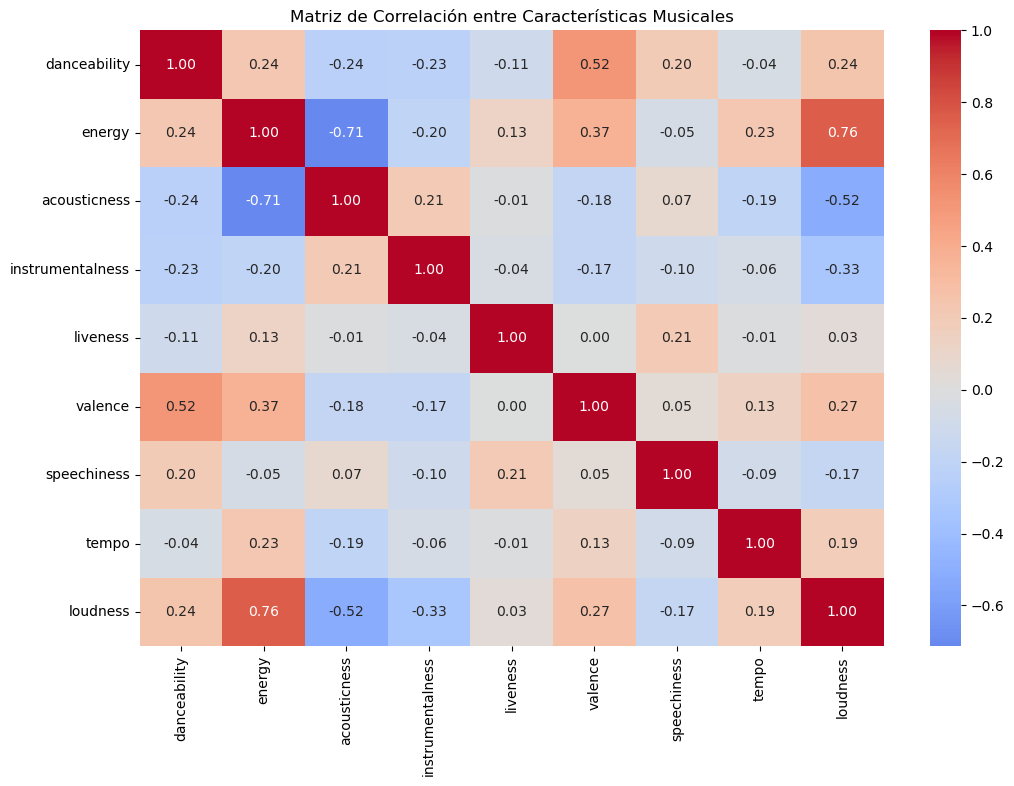

In [11]:
# Calcular matriz de correlación
corr_matrix = tracks_clean.select(audio_features).toPandas().corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Matriz de Correlación entre Características Musicales')
plt.show()

#### Analisis de tendencias musicales

In [ ]:
from pyspark.sql.functions import floor

# Crear columna de década (1985 → 1980, 1999 → 1990)
tracks_clean = tracks_clean.withColumn(
    "decade", 
    (floor(F.col("release_year") / 10) * 10).cast("int")
)

# Filtrar décadas con suficiente data 
tracks_decades = tracks_clean.filter(F.col("decade") >= 1920)

+------+---------+
|decade|num_songs|
+------+---------+
|  1920|     7601|
|  1930|    12951|
|  1940|    17772|
|  1950|    33747|
|  1960|    45956|
|  1970|    61043|
|  1980|    81811|
|  1990|   108603|
|  2000|    86617|
|  2010|   104899|
|  2020|    20175|
+------+---------+



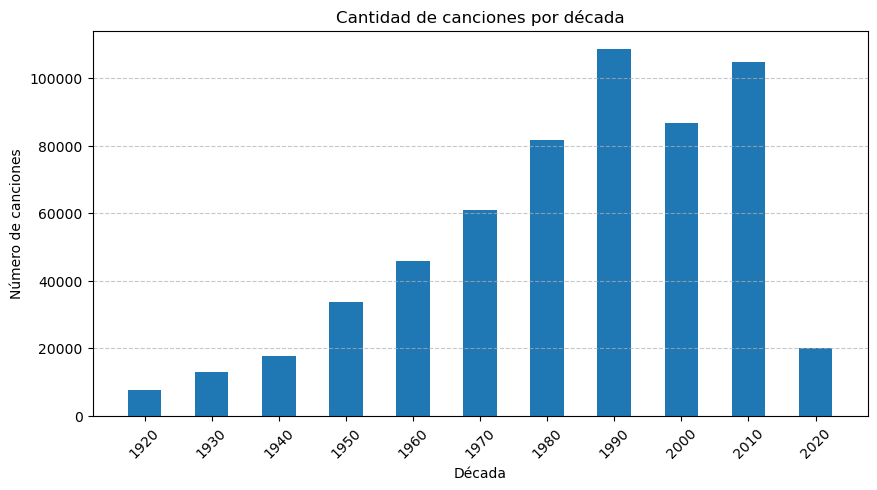

In [ ]:
# Contar canciones por década
songs_per_decade = tracks_decades.groupBy("decade").agg(
    count("*").alias("num_songs")
).orderBy("decade")

songs_per_decade.show()

# Visualización
songs_pd = songs_per_decade.toPandas()

plt.figure(figsize=(10, 5))
plt.bar(songs_pd["decade"], songs_pd["num_songs"], width=5)
plt.title("Cantidad de canciones por década")
plt.xlabel("Década")
plt.ylabel("Número de canciones")
plt.xticks(songs_pd["decade"], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

+------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+-------------------+
|decade|   avg_danceability|         avg_energy|   avg_acousticness|avg_instrumentalness|       avg_liveness|       avg_valence|    avg_speechiness|         avg_tempo|       avg_loudness|
+------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+-------------------+
|  1920| 0.6044980793360142| 0.2812560004310782| 0.8901129881148706|   0.326112140799257|0.20462332590272506| 0.599909460633175|0.29171081411264715|113.12064880754521|-14.789149192818966|
|  1930| 0.5522448380800824|0.30675858720909915| 0.8693819365754384|  0.2748463023123956| 0.2171209483216082|0.5725666805669919|0.19446495251630702|112.83728768987349|-13.522719249515891|
|  1940| 0.4771832490300887|0.26853156766032454| 0.914683427

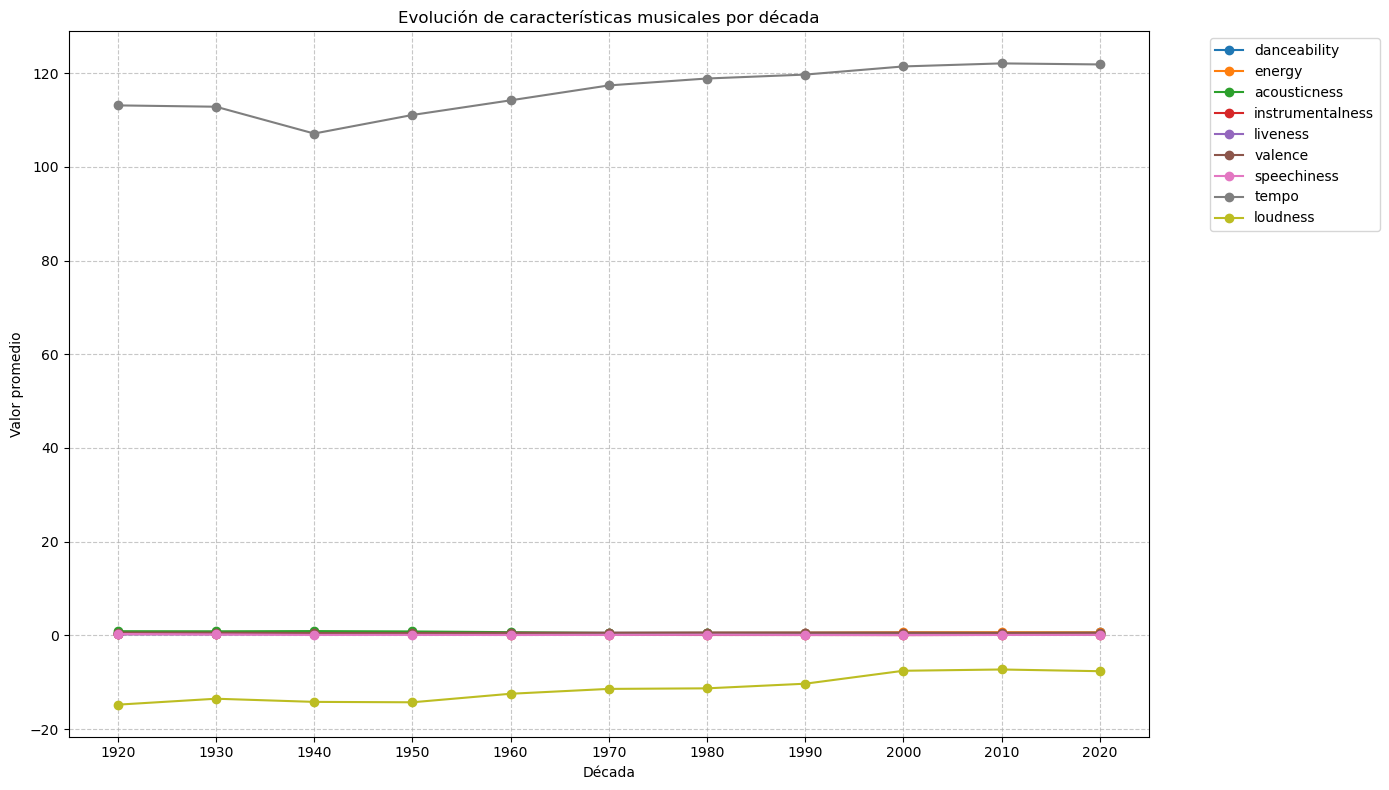

In [14]:
# Calcular promedios de características por década
features_by_decade = tracks_decades.groupBy("decade").agg(
    *[mean(feature).alias(f"avg_{feature}") for feature in audio_features]
).orderBy("decade")

# Mostrar resultados
features_by_decade.show()

# Preparar datos para visualización
features_pd = features_by_decade.toPandas()
features_pd.set_index("decade", inplace=True)

# Visualización de tendencias
plt.figure(figsize=(14, 8))
for feature in audio_features:
    plt.plot(features_pd.index, features_pd[f"avg_{feature}"], label=feature, marker='o')

plt.title("Evolución de características musicales por década")
plt.xlabel("Década")
plt.ylabel("Valor promedio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(features_pd.index)
plt.tight_layout()
plt.show()

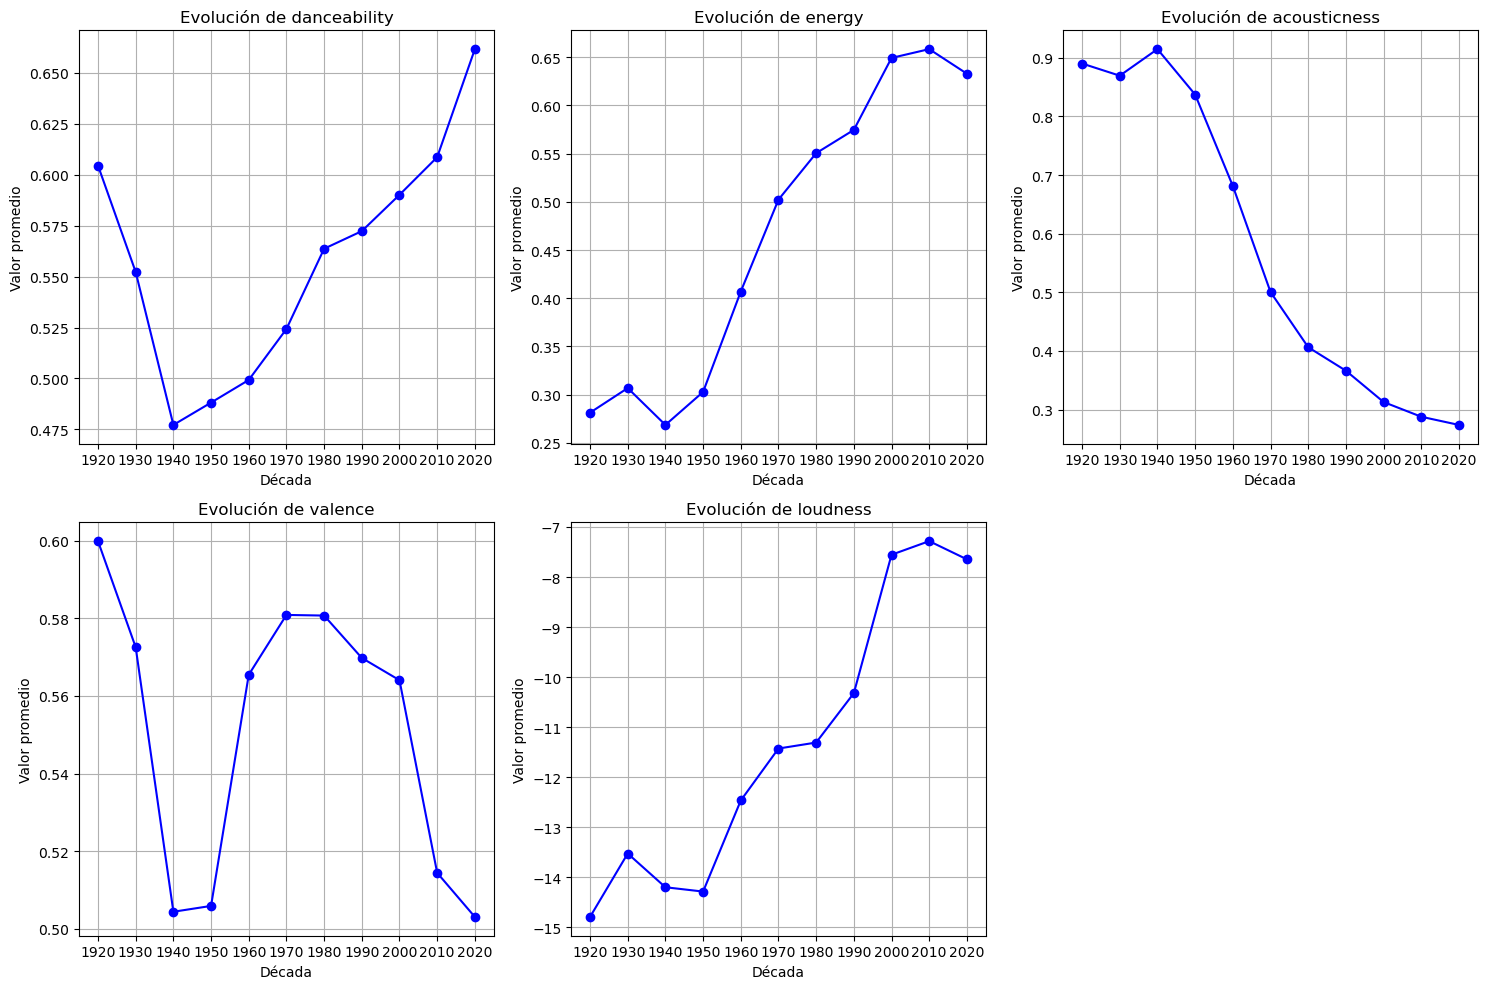

In [15]:
# Seleccionamos características más interesantes para visualización individual
key_features = ['danceability', 'energy', 'acousticness', 'valence', 'loudness']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    plt.plot(features_pd.index, features_pd[f"avg_{feature}"], 'b-o')
    plt.title(f"Evolución de {feature}")
    plt.xlabel("Década")
    plt.ylabel("Valor promedio")
    plt.grid(True)
    plt.xticks(features_pd.index)

plt.tight_layout()
plt.show()

#### Analisis de popularidad de canciones

In [16]:
from pyspark.sql.functions import when

# Definir categorías de popularidad basadas en cuartiles
tracks_pop = tracks_clean.withColumn(
    "popularity_category",
    when(F.col("popularity") < 25, "Muy baja")
    .when((F.col("popularity") >= 25) & (F.col("popularity") < 50), "Baja")
    .when((F.col("popularity") >= 50) & (F.col("popularity") < 75), "Media")
    .otherwise("Alta")
)

# Verificar distribución de categorías
pop_category_dist = tracks_pop.groupBy("popularity_category").agg(
    count("*").alias("count"),
    (count("*") / tracks_pop.count() * 100).alias("percentage")
).orderBy("popularity_category")

pop_category_dist.show()

+-------------------+------+------------------+
|popularity_category| count|        percentage|
+-------------------+------+------------------+
|               Alta|  2994|0.5133058335819283|
|               Baja|245181| 42.03501589293613|
|              Media| 72646|12.454781424980883|
|           Muy baja|262457| 44.99689684850105|
+-------------------+------+------------------+



/tmp/ipykernel_140/3891967660.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


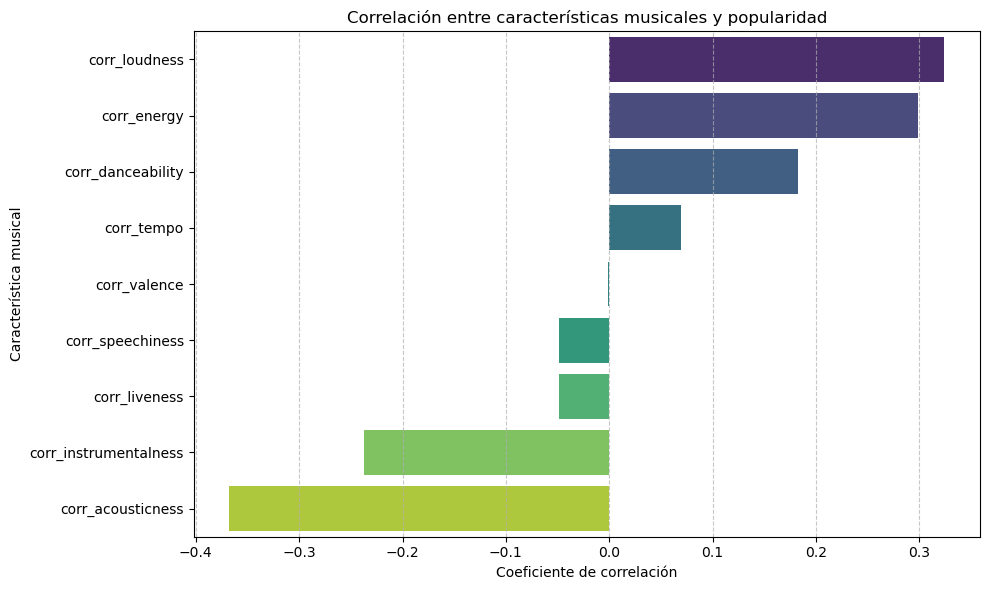

In [17]:
# Calcular correlaciones con popularidad
corr_with_popularity = tracks_pop.select(
    *[F.corr("popularity", feature).alias(f"corr_{feature}") 
      for feature in audio_features]
)

# Mostrar correlaciones ordenadas
corr_with_popularity_pd = corr_with_popularity.toPandas().transpose()
corr_with_popularity_pd.columns = ["Correlación"]
corr_with_popularity_pd = corr_with_popularity_pd.sort_values("Correlación", ascending=False)


# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Correlación", 
    y=corr_with_popularity_pd.index, 
    data=corr_with_popularity_pd,
    palette="viridis"
)
plt.title("Correlación entre características musicales y popularidad")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Característica musical")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

+-------------------+------------------+------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+-------------------+
|popularity_category|  avg_danceability|        avg_energy|   avg_acousticness|avg_instrumentalness|       avg_liveness|       avg_valence|    avg_speechiness|         avg_tempo|       avg_loudness|
+-------------------+------------------+------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+-------------------+
|               Alta| 0.656374080881785|0.6454011588983178|0.23674205052298608|0.018535321728882833|0.17067798934802264|0.5197637207335939|0.09962528406996367|121.61654372460538| -6.520884769434282|
|               Baja|0.5784545405457918|0.5945791638966107|0.36268909223585655| 0.07128187827782011|0.21682187237645337|0.5622008281699867|0.10822655146574159|119.74502116294673| -9.350096744992559|
|    

/tmp/ipykernel_140/430814794.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_140/430814794.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_140/430814794.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_140/430814794.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_140/430814794.py:19: FutureWarning: 

Passing `pa

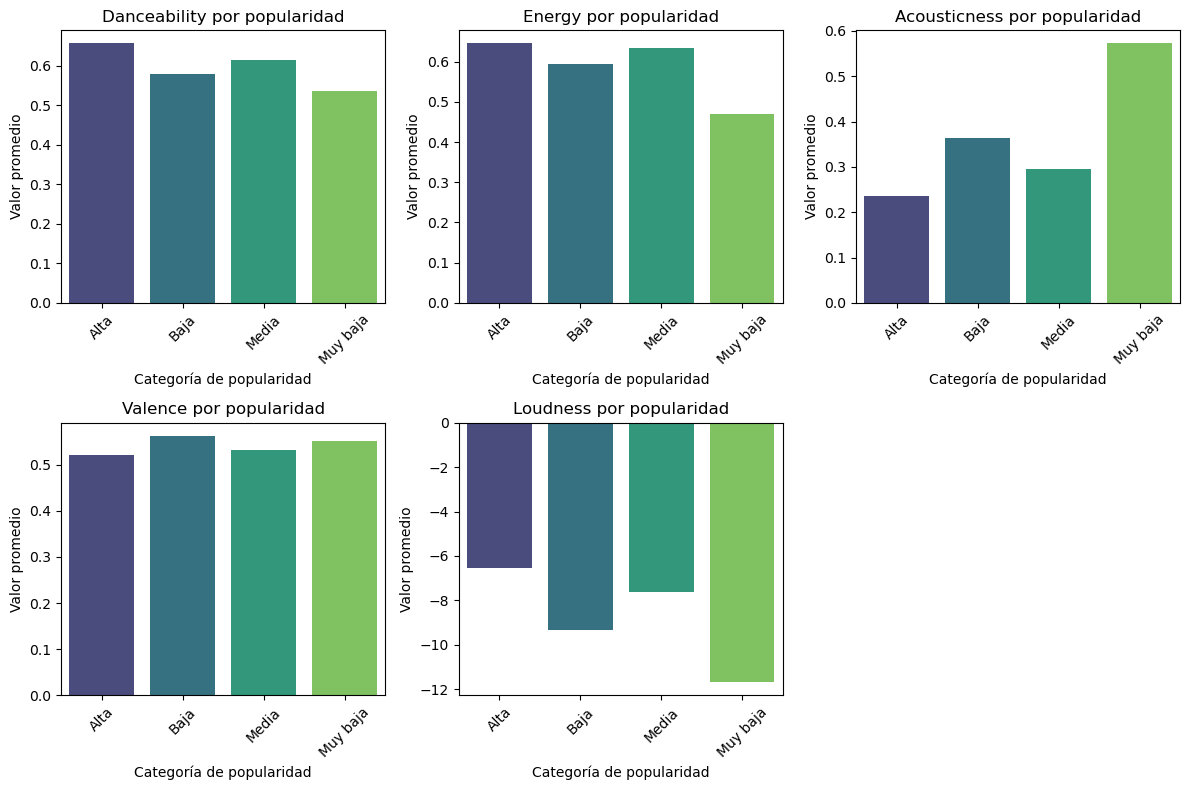

In [ ]:
# Calcular promedios por categoría de popularidad
features_by_popularity = tracks_pop.groupBy("popularity_category").agg(
    *[mean(feature).alias(f"avg_{feature}") for feature in audio_features]
).orderBy("popularity_category")

features_by_popularity.show()

# Preparar datos para visualización
features_pop_pd = features_by_popularity.toPandas()
features_pop_pd.set_index("popularity_category", inplace=True)

# Visualización de características clave
key_features = ['danceability', 'energy', 'acousticness', 'valence', 'loudness']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(
        x=features_pop_pd.index, 
        y=features_pop_pd[f"avg_{feature}"],
        palette="viridis"
    )
    plt.title(f"{feature.capitalize()} por popularidad")
    plt.xlabel("Categoría de popularidad")
    plt.ylabel("Valor promedio")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [19]:
from pyspark.sql.functions import stddev, mean

# Calcular media y desviación estándar por categoría
mean_features = [mean(feature).alias(f"mean_{feature}") for feature in audio_features]
stddev_features = [stddev(feature).alias(f"std_{feature}") for feature in audio_features]

stats_by_popularity = tracks_pop.groupBy("popularity_category").agg(
    *mean_features, *stddev_features
).orderBy("popularity_category")

# Mostrar estadísticas para características clave
for feature in key_features:
    stats_by_popularity.select(
        "popularity_category",
        f"mean_{feature}",
        f"std_{feature}"
    ).show()


+-------------------+------------------+-------------------+
|popularity_category| mean_danceability|   std_danceability|
+-------------------+------------------+-------------------+
|               Alta| 0.656374080881785|0.14861766080909575|
|               Baja|0.5784545405457918|0.16149717881512773|
|              Media|0.6147616056950144|0.16196902877206945|
|           Muy baja|0.5363731285933154| 0.1650409651632118|
+-------------------+------------------+-------------------+

+-------------------+------------------+-------------------+
|popularity_category|       mean_energy|         std_energy|
+-------------------+------------------+-------------------+
|               Alta|0.6454011588983178| 0.1822558764348347|
|               Baja|0.5945791638966107|0.23562876323726092|
|              Media|0.6339897453351749|0.21396956170455356|
|           Muy baja|0.4692451554897296| 0.2551395416547485|
+-------------------+------------------+-------------------+

+-------------------+-

/tmp/ipykernel_140/3848826693.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_140/3848826693.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_140/3848826693.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_140/3848826693.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_140/3848826693.py:9: FutureWarning: 

Passing `pa

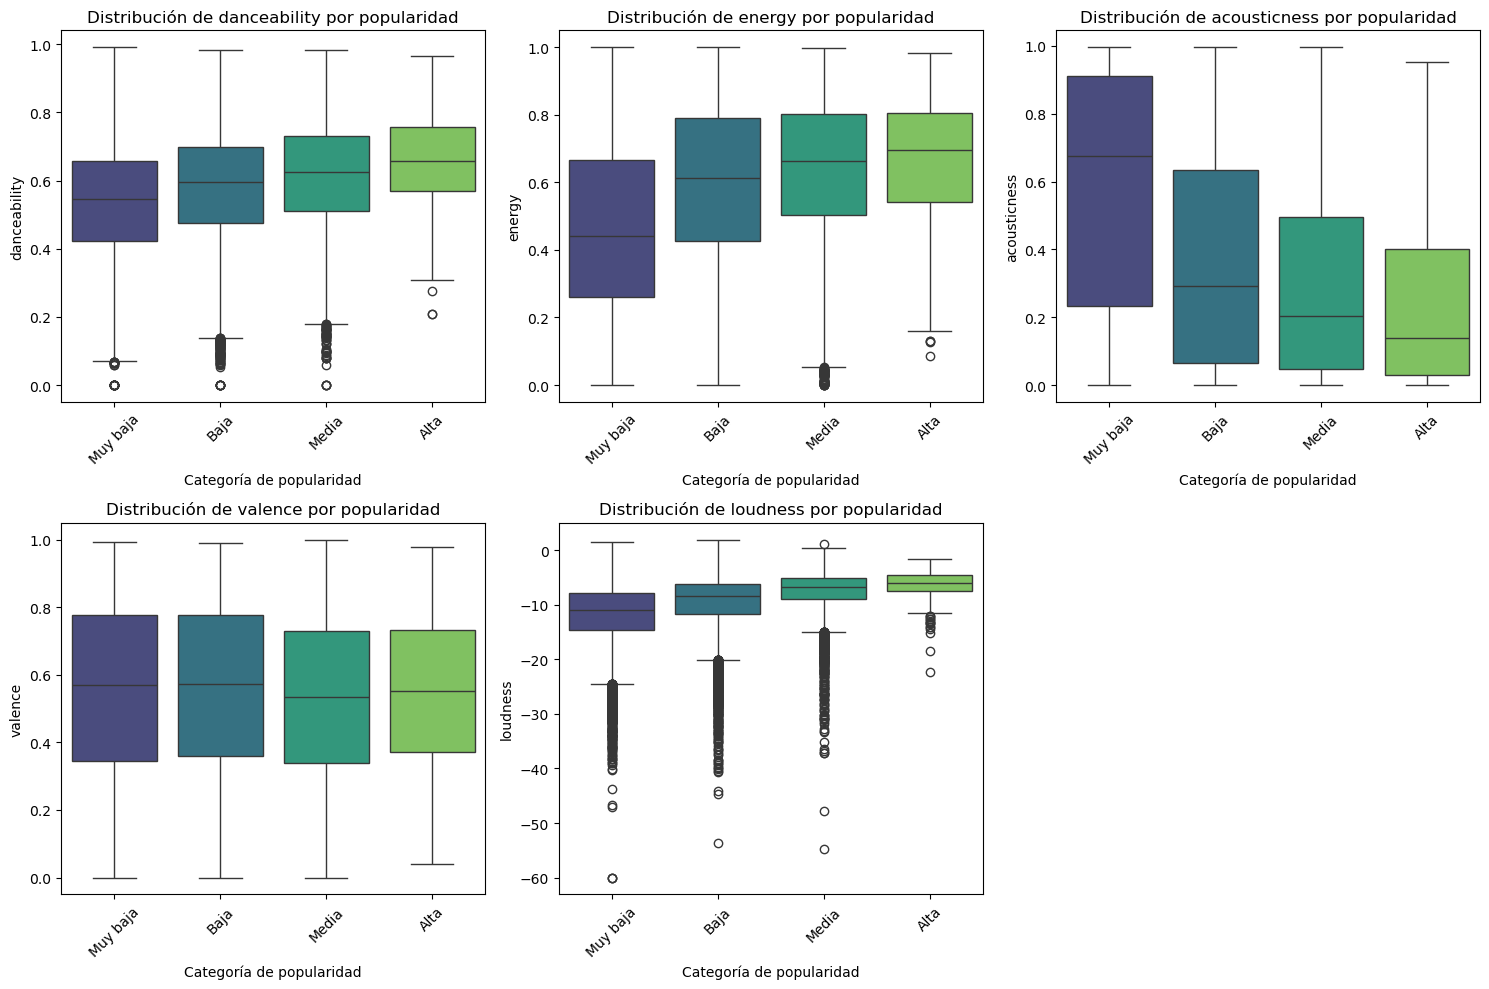

In [20]:
# Muestrear datos para visualización
sample_pop_pd = tracks_pop.sample(fraction=0.1, seed=42).select(
    "popularity_category", *key_features).toPandas()

# Crear boxplots para cada característica
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        x="popularity_category", 
        y=feature, 
        data=sample_pop_pd,
        order=["Muy baja", "Baja", "Media", "Alta"],
        palette="viridis"
    )
    plt.title(f"Distribución de {feature} por popularidad")
    plt.xlabel("Categoría de popularidad")
    plt.ylabel(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Preguntas para analizar

Evolución del Género Musical: ¿Cómo han cambiado las preferencias musicales a lo largo del tiempo?

In [21]:
tracks_df.printSchema()
artists_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- duration_min: double (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- artists_array: array (nullable = true)
 |    |-- element: string (containsNull = false)

root
 |-- id: st

In [ ]:
from pyspark.sql.functions import col, explode, split, count, row_number, floor
from pyspark.sql.window import Window

# Preparar datos básicos
tracks_clean = tracks_df.withColumn(
    "decade", (floor(col("release_year")/10)*10)
).filter(
    col("decade").between(1970, 2020)
)

# Explode de artistas (asumiendo id_artists como string separado por comas)
tracks_exploded = tracks_clean.withColumn(
    "artist_id", 
    explode(split(regexp_replace(col("id_artists"), r"[\[\]\']", ""), ",\s*"))
)

# Join con artistas
joined_df = tracks_exploded.join(
    artists_df,
    trim(tracks_exploded["artist_id"]) == trim(artists_df["id"]),
    "left"
)

# Explode de géneros (asumiendo genres como string separado por comas)
joined_df = joined_df.withColumn(
    "genre",
    explode(split(regexp_replace(col("genres"), r"[\[\]\']", ""), ",\s*"))
).filter(
    trim(col("genre")) != ""
)

# Contar géneros por década
genre_counts = joined_df.groupBy("decade", "genre").count()

# Seleccionar top 5 por década
window_spec = Window.partitionBy("decade").orderBy(col("count").desc())

top_genres = genre_counts.withColumn(
    "rank", 
    row_number().over(window_spec)
).filter(
    col("rank") <= 5
).orderBy("decade", "rank")

# Mostrar resultados
top_genres.select("decade", "genre", "count").show(50, truncate=False)

+------+---------------+-----+
|decade|genre          |count|
+------+---------------+-----+
|1970  |classic rock   |9919 |
|1970  |rock           |9479 |
|1970  |album rock     |7478 |
|1970  |mellow gold    |7475 |
|1970  |soft rock      |6563 |
|1980  |rock           |7988 |
|1980  |soft rock      |5250 |
|1980  |album rock     |4946 |
|1980  |hoerspiel      |4894 |
|1980  |mellow gold    |4860 |
|1990  |rock           |5403 |
|1990  |filmi          |3825 |
|1990  |latin          |3628 |
|1990  |rock en espanol|3527 |
|1990  |c-pop          |3350 |
|2000  |filmi          |4172 |
|2000  |latin          |3918 |
|2000  |dance pop      |3842 |
|2000  |rock en espanol|2708 |
|2000  |tropical       |2648 |
|2010  |pop            |7617 |
|2010  |dance pop      |5876 |
|2010  |latin          |5171 |
|2010  |pop dance      |5041 |
|2010  |edm            |4809 |
|2020  |trap latino    |2554 |
|2020  |latin          |2254 |
|2020  |reggaeton      |2131 |
|2020  |pop            |1931 |
|2020  |

#### Características Distintivas por Género

In [113]:
# Seleccionamos 3 géneros contrastantes
selected_genres = ['rock', 'filmi', 'dance pop']

# Calculamos promedios de características
genre_features = joined_df.filter(
    col('genre').isin(selected_genres)
).groupBy('genre').agg(
    avg('danceability').alias('danceability'),
    avg('energy').alias('energy'),
    avg('speechiness').alias('speechiness'),
    avg('acousticness').alias('acousticness'),
    avg('instrumentalness').alias('instrumentalness'),
    avg('valence').alias('valence'),
    avg('tempo').alias('tempo_norm')  # Normalizamos tempo para comparación
).toPandas()

# Normalización de tempo (para escala 0-1)
genre_features['tempo'] = (genre_features['tempo_norm'] - genre_features['tempo_norm'].min()) / (genre_features['tempo_norm'].max() - genre_features['tempo_norm'].min())

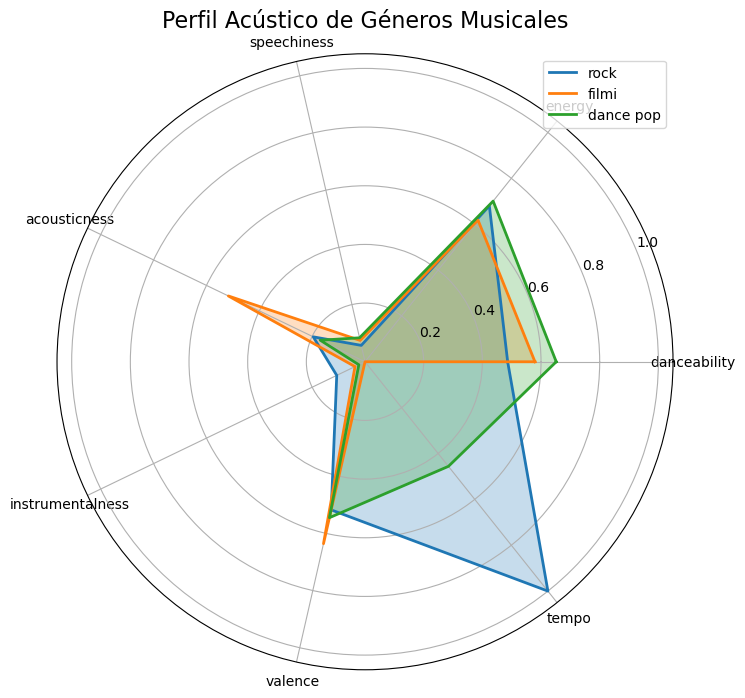

In [61]:
import numpy as np

## Visualización Radar Chart
categories = ['danceability','energy','speechiness','acousticness','instrumentalness','valence','tempo']
N = len(categories)
angles = [n / N * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for idx, genre in enumerate(selected_genres):
    values = genre_features[genre_features['genre']==genre][categories].values[0].tolist()
    values += values[:1]
    ax.plot(angles, values, label=genre, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Perfil Acústico de Géneros Musicales', size=16)
plt.legend(loc='upper right')
plt.show()

#### Modelo de prediccion de popularidad

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Definir variable objetivo (popularidad > 70)
df_ml = tracks_df.withColumn(
    "label", 
    when(col("popularity") > 70, 1).otherwise(0)
)

# Seleccionar características de audio
feature_cols = [
    "danceability", "energy", "speechiness", 
    "acousticness", "instrumentalness",
    "liveness", "valence", "tempo",
    "loudness", "duration_ms"
]

# Limpieza de datos
df_ml = df_ml.select(["label"] + feature_cols).na.drop()

# División entrenamiento/test (80/20)
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Ensamblador de características
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Modelo Random Forest
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=100,
    maxDepth=5,
    seed=42
)

# Pipeline
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(train_data)

In [ ]:
# Predecir sobre test
predictions = model.transform(test_data)

# Evaluador (AUC)
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(predictions)

# Métricas adicionales
accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="accuracy"
).evaluate(predictions)

precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
).evaluate(predictions)

print(f"""
Métricas del Modelo:
- AUC: {auc:.3f}
- Accuracy: {accuracy:.3f}
- Precision: {precision:.3f}
""")


Métricas del Modelo:
- AUC: 0.754
- Accuracy: 0.989
- Precision: 0.979



#### Analisis de Outliers

In [ ]:
## Verificar las columnas disponibles
print("Columnas en joined_df:", joined_df.columns)


Columnas en joined_df: ['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists', 'id_artists', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'release_year', 'artists_array', 'decade', 'artist_id', 'id', 'followers', 'genres', 'name', 'popularity', 'genre']


In [ ]:
from pyspark.sql.functions import col, mean, stddev, abs

# Calcular media y desviación estándar de tempo
stats_tempo = tracks_clean.agg(
    mean('tempo').alias('mean_tempo'),
    stddev('tempo').alias('std_tempo')
).collect()[0]

mean_tempo = stats_tempo['mean_tempo']
std_tempo = stats_tempo['std_tempo']

# Calcular Z-score y filtrar outliers (|Z| > 3)
tracks_outliers = tracks_clean.withColumn(
    'z_score_tempo', 
    (col('tempo') - mean_tempo) / std_tempo
).filter(
    abs(col('z_score_tempo')) > 3
)

# Mostrar resultados
print(f"Número de outliers en tempo: {tracks_outliers.count()}")
print(f"Media de tempo: {mean_tempo:.2f}")
print(f"Desviación estándar de tempo: {std_tempo:.2f}")


Número de outliers en tempo: 659
Media de tempo: 120.20
Desviación estándar de tempo: 29.26


In [92]:
# Mostrar ejemplos si hay outliers
print("\nEjemplos de outliers:")
tracks_outliers.select('name', 'artists', 'tempo', 'z_score_tempo').show(5)



Ejemplos de outliers:
+--------------------+-----------------+-------+------------------+
|                name|          artists|  tempo|     z_score_tempo|
+--------------------+-----------------+-------+------------------+
|Candyman - 2013 R...|['Grateful Dead']|236.799|3.9849875630782274|
|       It's Too Late|  ['Carole King']|208.282|3.0103443151719413|
|     Call The Doctor|    ['J.J. Cale']|243.372| 4.209637019501074|
|Jesus Just Left C...|       ['ZZ Top']|215.918| 3.271324706997831|
|Lovin', Touchin',...|      ['Journey']| 211.27| 3.112467281259568|
+--------------------+-----------------+-------+------------------+
only showing top 5 rows



## Sistema de Recomendacion Musical

#### Definicion de Perfiles Musicales con Clustering

In [95]:
audio_features

['danceability',
 'energy',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo_norm']

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, isnan, when, count


tracks_clean = tracks_df.na.drop(subset=audio_features)

## 1. Normalización de características numéricas
for feature in audio_features:
    tracks_clean = tracks_clean.withColumn(feature, col(feature).cast("double"))



In [ ]:
## Pipeline de clustering
assembler = VectorAssembler(
    inputCols=audio_features,
    outputCol="features",
    handleInvalid="skip"  
)

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

kmeans = KMeans(
    featuresCol="scaled_features",
    k=10,  
    seed=42,
    maxIter=50,
    tol=1e-6
)

pipeline = Pipeline(stages=[assembler, scaler, kmeans])



In [ ]:
## Entrenamiento con validación

model = pipeline.fit(tracks_clean)
clustered_tracks = model.transform(tracks_clean)
    
# Evaluación de clusters
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clustered_tracks)
print(f"Silhouette score: {silhouette:.3f}")
    
# Mostrar distribución de clusters
print("\nDistribución de clusters:")
clustered_tracks.groupBy("prediction").count().orderBy("prediction").show()
    


Silhouette score: -0.179

Distribución de clusters:
+----------+------+
|prediction| count|
+----------+------+
|         0|161198|
|         1|    15|
|         2|    57|
|         3|    19|
|         4| 26904|
|         5|109590|
|         6|146764|
|         7| 23650|
|         8| 91972|
|         9| 24111|
+----------+------+



#### Motor de Recomendación

In [107]:
from pyspark.ml.feature import MinHashLSH
from pyspark.sql.functions import rand

class MusicRecommender:
    def __init__(self, tracks_df, model):
        self.tracks = tracks_df
        self.model = model
        self._prepare_similarity_model()
    
    def _prepare_similarity_model(self):
        mh = MinHashLSH(inputCol="scaled_features", outputCol="hashes", numHashTables=5)
        self.similarity_model = mh.fit(model.transform(self.tracks))
    
    def recommend(self, seed_track_id, num_recs=10, diversity_weight=0.3):
        # Obtener características de la canción semilla
        seed_features = self.tracks.filter(col("id") == seed_track_id)
        
        # Encontrar canciones similares
        similar_tracks = self.similarity_model.approxNearestNeighbors(
            self.tracks, seed_features.first()["scaled_features"], num_recs*3
        )
        
        # Aplicar diversidad
        recommendations = similar_tracks.orderBy(
            (1-diversity_weight)*col("distCol") + 
            diversity_weight*(rand() + 0.5*col("popularity")/100 + 0.2*col("decade")/50)
        ).limit(num_recs)
        
        return recommendations

#### Evaluación del sistema con métricas como:

Diversidad de recomendaciones,
Novedad (serendipity),
Precisión de las recomendaciones

In [108]:
from pyspark.sql.functions import collect_list

def evaluate_recommendations(recommendations):
    # Diversidad de género
    genre_diversity = recommendations.agg(
        countDistinct("genre").alias("unique_genres")
    ).first()["unique_genres"]
    
    # Novedad (promedio de popularidad inversa)
    novelty = recommendations.agg(
        (1 - avg(col("popularity")/100)).alias("novelty")
    ).first()["novelty"]
    
    # Precisión simulada (basada en características)
    precision = recommendations.agg(
        avg(col("distCol")).alias("avg_distance")
    ).first()["avg_distance"]
    
    return {
        "genre_diversity": genre_diversity,
        "novelty": novelty,
        "precision": 1 - precision
    }

####  Interfaz Conceptual

+-----------------------------+

| **Perfil del Usuario:**      |

| **Clúster 3 - Pop Energético** |

+-----------------------------+

| **Recomendaciones:**        |


| 1. **[2023] Canción A** ★★★★☆  |

|    *Pop | Dance | 120 BPM*   |


| 2. **[2018] Canción B** ★★★★   |

|    *Electropop | 115 BPM*    |


| 3. **[1999] Canción C** ★★★★☆  |

|    *Pop Rock | 118 BPM*      |

+-----------------------------+

| **Opciones:**               |

| - Refinar recomendaciones   |

| - Explorar géneros          |

| - Descubrir nuevas          |

+-----------------------------+



#### Escalabilidad: Arquitectura de Big Data para Escalar el Sistema de Recomendacion

#### 📦 Almacenamiento:
- **Hadoop**: para el feature store  
- **DynamoDB**: para embeddings y modelos en producción  

#### ⚙️ Procesamiento:
- **Spark**: para procesamiento de la data  
- **Kafka**: para recibir la data en tiempo real  
- **Particionar datos** por región/idioma para procesamiento paralelo  

#### 🚀 Serving:
- **Microservicios** con balanceo de carga  
- **Cache distribuido (Redis)** para recomendaciones frecuentes  

#### 🔧 Optimizaciones:
- **Approximate Nearest Neighbors (ANN)** para búsqueda eficiente  
- **Precomputar clusters** para usuarios frecuentes  
